# Moving Average Crossover Strategy

Moving average crossover strategy (MACS) is a trading strategy that generates buy/sell signals based on a slow moving average and a fast moving average. When the fast moving average curve crosses the slow moving average curve and becomes larger (smaller), a buy (sell) signal is generated. 

In this notebook, we apply MACS to EUR/USD rates.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import utilities as ut

### Explore data

In [4]:
ticker = "EURUSD=X"
start = "2004-01-01"
end = "2024-12-31"
df = ut.get_data(ticker, start=start, end=end)
df = ut.get_logreturns(df=df)

[*********************100%***********************]  1 of 1 completed


In [5]:
df.head()

,Price,Log Returns
Date,,
2004-01-01,1.258194,NaN
2004-01-02,1.258194,0.000000
2004-01-05,1.268698,0.008313
2004-01-06,1.272103,0.002681
2004-01-07,1.264095,-0.006315


In [6]:
slow = 200
fast = 50
df["Slow"] = df["Price"].rolling(slow).mean()
df["Fast"] = df["Price"].rolling(fast).mean()
df.dropna(inplace=True)
# position
df["Position"] = np.where(df["Slow"] < df["Fast"], -1, 1)

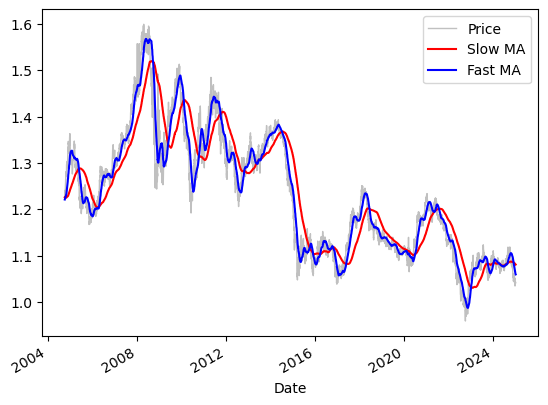

In [7]:
df["Price"].plot(label="Price",c='silver',lw=1)
df["Slow"].plot(label="Slow MA",c='red')
df["Fast"].plot(label="Fast MA",c='blue')
plt.legend()


### Moving average crossover strategy

In [8]:
df["Position MACS"] = np.where(df["Slow"] < df["Fast"], 1, -1)
df["Returns MACS"] = df["Position MACS"].shift(1) * df["Log Returns"]
df.dropna(inplace=True)

### Compare MACS and buy-and-hold

0.8492329352034452


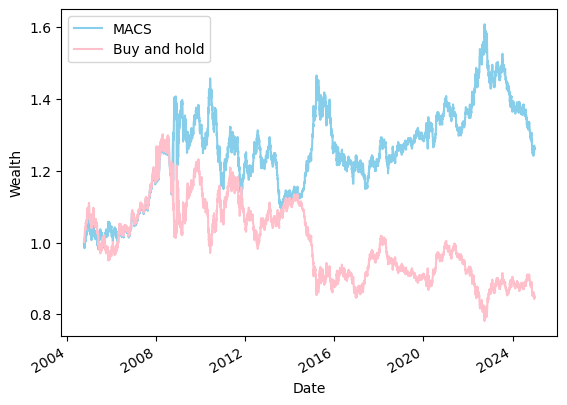

In [9]:
(df["Returns MACS"].cumsum()).apply(np.exp).plot(label='MACS', c='skyblue')
(df["Log Returns"].cumsum()).apply(np.exp).plot(label='Buy and hold', c='pink')
plt.ylabel('Wealth')
plt.legend()
print(np.exp((df["Log Returns"].cumsum())[-1]))

### Outperformance or underperformance of different slow and fast windows w.r.t. buy-and-hold

In [10]:
df_raw = ut.get_data(ticker, start=start, end=end)
df_raw = ut.get_logreturns(df=df_raw)
def outperformance_macs(data, slow, fast):
    data["Slow"] = data["Price"].rolling(slow).mean()
    data["Fast"] = data["Price"].rolling(fast).mean()
    data.dropna(inplace=True)
    data["Position MACS"] = np.where(data["Slow"] < data["Fast"], -1, 1)
    data["Returns MACS"] = data["Position MACS"].shift(1) * data["Log Returns"]
    return np.exp((data["Returns MACS"].cumsum())[-1]) - np.exp((data["Log Returns"].cumsum())[-1])
fast_windows = range(10, 60, 1)
slow_windows = range(100, 200, 2)

performance = []
for slow in slow_windows:
    p = []
    for fast in fast_windows:
        p.append(outperformance_macs(df_raw.copy(), slow, fast))
    performance.append(p)

performance = np.array(performance)
best = np.unravel_index(np.argmax(performance, axis=None), performance.shape)
print(f"Best performance achieved for: \nslow window: {slow_windows[best[0]]} | fast window: {fast_windows[best[1]]}")

[*********************100%***********************]  1 of 1 completed
Best performance achieved for: 
slow window: 106 | fast window: 12


Text(0.5, 1.0, 'Overperformance in comparison to buy-and-hold')

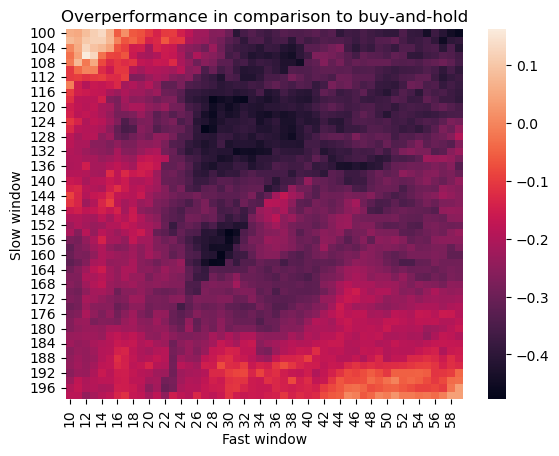

In [11]:
result = pd.DataFrame(index=slow_windows, columns=fast_windows, data=performance)
sns.heatmap(result)
plt.xlabel("Fast window")
plt.ylabel("Slow window")
plt.title("Overperformance in comparison to buy-and-hold")